# Julia in Kaggle - updated Julia ver
Jan 2022
based on:
[@marketneutral](https://www.kaggle.com/marketneutral)

In [1]:
from datetime import datetime
import numpy as np
from IPython.display import Image, display

# Install Julia

In [2]:
%%bash
JULIA_VERSION="1.7.2"
JULIA_PACKAGES="IJulia BenchmarkTools PyCall PyPlot"
JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
#https://julialang-s3.julialang.org/bin/linux/x64/1.7/julia-1.7.2-linux-x86_64.tar.gz
BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
wget -nv $URL -O /tmp/julia.tar.gz
tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
rm /tmp/julia.tar.gz
for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'"'
done

Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing Julia package PyCall...
Installing Julia package PyPlot...


2022-02-23 05:29:52 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.7/julia-1.7.2-linux-x86_64.tar.gz [123295596/123295596] -> "/tmp/julia.tar.gz" [1]
┌ Warning: The Pkg REPL mode is intended for interactive use only, and should not be used from scripts. It is recommended to use the functional API instead.
└ @ Pkg.REPLMode /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.7/Pkg/src/REPLMode/REPLMode.jl:377
  Installing known registries into `~/.julia`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Parsers ───────── v2.2.2
   Installed Conda ─────────── v1.7.0
   Installed VersionParsing ── v1.3.0
   Installed JSON ──────────── v0.21.3
   Installed ZMQ ───────────── v1.2.1
   Installed IJulia ────────── v1.23.2
   Installed Preferences ───── v1.2.3
   Installed JLLWrappers ───── v1.4.1
   Installed SoftGlobalScope ─ v1.1.0
   Installed ZeroMQ_jll ────── v4.3.4+0
   Installed libsodium_jll ─── v1.0

In [4]:
%%bash 
# Install kernel and rename it to "julia"
echo "Installing IJulia kernel..."
julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

echo ''
echo "Successfully installed `julia -v`!"

Installing IJulia kernel...



[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.7
mv: cannot move '/root/.local/share/jupyter/kernels/julia' to a subdirectory of itself, '/root/.local/share/jupyter/kernels/julia/julia'


In [6]:
# we set the environment variable for number of threads

import os
os.environ['JULIA_NUM_THREADS'] = "4"

In [7]:
%%bash

julia -e 'println("Hello Julia.")'
julia -e 'using Base.Threads; println(nthreads())'

Hello Julia.
4


# Running Julia in Notebook cells

You can use a Jupyter cell magic to run Julia code. This creates a single Julia session which persists over cells.

In [8]:
%%time
!pip install --quiet julia
import julia
from julia.api import Julia
julia.install()
jl = Julia(compiled_modules=False)  # cannot use precompiled packages with pyjulia on linux :-(
%load_ext julia.magic

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Initializing Julia interpreter. This may take some time...
CPU times: user 22.2 s, sys: 663 ms, total: 22.9 s
Wall time: 35.5 s


We can run arbitrary Julia code in a cell.

In [9]:
%%julia

using Base.Threads
println(nthreads())

function double(x)
    return x .* 2
end

x = [1, 2, 3];

4


The Julia session persists, so we can refernce objects and functions from before.

In [10]:
%%julia

println(x)
double(x)

[1, 2, 3]


array([2, 4, 6], dtype=int64)

# Julia and Python interaction

We can return the vector to Python as a numpy array. Note the single "%".

In [11]:
y = %julia double(x)
print(type(y))
print(y)

<class 'numpy.ndarray'>
[2 4 6]


And we can go back and forth between Python and Julia.

In [12]:
# this is a Python numpy array
z = np.array([7, 8, 9])    

# we pass it to a Julia function and get back a Python numpy array
a = %julia double($z)      

print(type(a))
print(a)

<class 'numpy.ndarray'>
[14 16 18]


To be honest, I'm not sure if this is making copies or not when objects are passed back and forth. If you were to use Julia for real in a Kaggle kernel, I imagine the safest thing is to pass objects via caching to file. Julia supports `csv`, `hdf5`, etc. of course. Importantly, Julia supports `feather` for interoperability between `pandas` and Julia.

Here is a simple example. Say we want to do some expensive feature engineering and take advantage of Julia's easy multithreading. Here is what we will do
- load the data inside the Julia session
- do our multithreded feature engineering
- save it as a feather file
- come back to Python and load the feather file and we are off to our ML pipeline.

In [27]:
%%julia
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Feather")
Pkg.add("RollingFunctions")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
   Installed IrrationalConstants ─ v0.1.1
   Installed StatsAPI ──────────── v1.2.1
   Installed RollingFunctions ──── v0.6.2
   Installed ChangesOfVariables ── v0.1.2
   Installed InverseFunctions ──── v0.1.2
   Installed LogExpFunctions ───── v0.3.6
   Installed StatsBase ─────────── v0.33.16
   Installed ChainRulesCore ────── v1.12.1
   Installed DocStringExtensions ─ v0.8.6
    Updating `~/.julia/environments/v1.7/Project.toml`
  [b0e4dd01] + RollingFunctions v0.6.2
    Updating `~/.julia/environments/v1.7/M

In [33]:
%%julia

import Base.Threads.@threads
using DataFrames,CSV, Feather, RollingFunctions

df=CSV.File("../input/property-sales/raw_sales.csv") |> DataFrame

gdf = groupby(df, :propertyType)
groups_ = Vector{Any}(undef, length(gdf))

@threads for (i, grp) in collect(enumerate(gdf))
    groups_[i] = transform(grp, :price => (x->runmean(x, 20)) => :roll_from_Julia)
end

df_out = vcat(groups_...)

Feather.write("engineered.feather", df_out)

'engineered.feather'

In [34]:
import pandas as pd

df = pd.read_feather('engineered.feather')
df.head()

,datesold,postcode,price,propertyType,bedrooms,roll_from_Julia
0,2007-02-07 00:00:00,2607,525000,house,4,525000.0
1,2007-02-27 00:00:00,2906,290000,house,3,407500.0
2,2007-03-07 00:00:00,2905,328000,house,3,381000.0
3,2007-03-09 00:00:00,2905,380000,house,4,380750.0
4,2007-03-21 00:00:00,2906,310000,house,3,366600.0


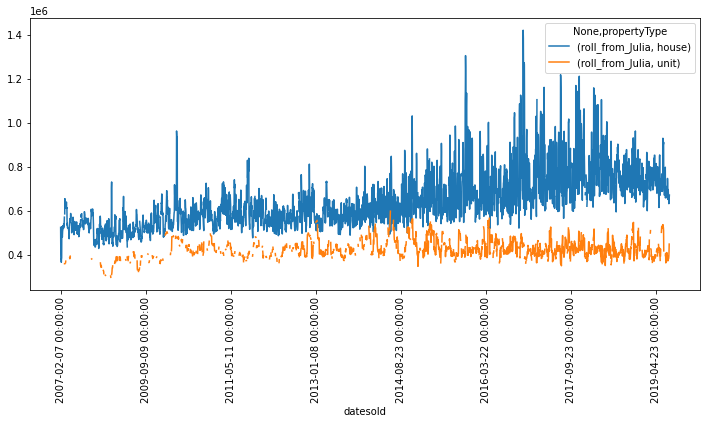

In [35]:
df[['datesold', 'propertyType', 'roll_from_Julia']].groupby(['datesold', 'propertyType']).last().unstack().plot(rot=90, figsize=(12,5));

Of course this example is trivial: there are two groups in a small dataset. It's just an example; the point is there's lots of great stuff about Julia, like the tiny `@threads` macro which can dramatically improve your life.

# Running Julia scripts directly

You can of course just pass a script file directly to Julia as if you were on the command line. This also seems like a very safe thing to do as you do not have to worry about weird memory issues with Jupyter notebooks.

In [37]:
!apt-get update

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease [5388 B]
Get:5 http://packages.cloud.google.com/apt cloud-sdk-bionic InRelease [6786 B]
Get:6 http://packages.cloud.google.com/apt cloud-sdk InRelease [6745 B]        
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Err:4 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY FEEA9169307EA071 NO_PUBKEY 8B57C5C2836F4BEB
Err:5 http://packages.cloud.google.com/apt cloud-sdk-bionic InRelease
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY FEEA9169307EA071 NO_PUBKEY 8B57C5C2836F4BEB
Get:8 http://security.ubuntu.com/ubuntu bionic-security/mu

In [38]:
!apt-get install -y qt5-default

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libdouble-conversion1 libdrm-amdgpu1 libdrm-common libdrm-dev libdrm-intel1
  libdrm-nouveau2 libdrm-radeon1 libdrm2 libegl-mesa0 libegl1 libegl1-mesa-dev
  libevdev2 libgbm1 libgl1-mesa-dev libglapi-mesa libgles1 libgles2
  libgles2-mesa-dev libglu1-mesa libglu1-mesa-dev libglvnd-core-dev
  libglvnd-dev libglx-mesa0 libgudev-1.0-0 libinput-bin libinput10 libmtdev1
  libopengl0 libpthread-stubs0-dev libqt5concurrent5 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5opengl5 libqt5opengl5-dev
  libqt5printsupport5 libqt5sql5 libqt5sql5-sqlite libqt5svg5 libqt5test5
  libqt5widgets5 libqt5xml5 libwacom-bin libwacom-common libwacom2
  libwayland-bin libwayland-dev libwayland-server0 libx11-6 libx11-dev
  libx11-doc libx11-xcb-dev libx11-xcb1 libxau-dev libxau6 libxcb-dri2-0-dev
  libxcb-dri3-dev libxcb-glx0-dev libxcb-icccm4 libxcb

Make a Julia script file.

In [45]:
%%writefile "ilovejulia.jl"

ENV["GKSwstype"] = "nul"
ENV["LD_LIBRARY_PATH"] = "nul"
using Plots

@userplot CirclePlot
@recipe function f(cp::CirclePlot)
    x, y, i = cp.args
    n = length(x)
    inds = circshift(1:n, 1 - i)
    linewidth --> range(0, 10, length = n)
    seriesalpha --> range(0, 1, length = n)
    aspect_ratio --> 1
    label --> false
    x[inds], y[inds]
end

n = 400
t = range(0, 2π, length = n)
x = 16sin.(t).^3
y = 13cos.(t) .- 5cos.(2t) .- 2cos.(3t) .- cos.(4t)

anim = @animate for i ∈ 1:n
    circleplot(x, y, i, line_z = 1:n, cbar = false, c = :reds, framestyle = :none)
end when i > 40 && mod1(i, 10) == 5

gif(anim, "ilovejulia.gif", fps = 15)


Overwriting ilovejulia.jl


Call it from the command line.

In [48]:
%%julia
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [49]:
%%bash

julia ilovejulia.jl

┌ Info: Saved animation to 
└   fn = "/kaggle/working/ilovejulia.gif"


Scroll down to see the output...

Enjoy Julia. If you make Julia kernels, please let me know.